# 1. 기초세팅

## 1-1) 필요 라이브러리 import

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_colwidth', 100)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm # color map

plt.style.use('ggplot')
# 그래프의 배경이 회색 격자(grid)로 설정됩니다, 이는 데이터 포인트 간의 비교를 용이하게 합니다.
# 라인과 색상 스키마가 ggplot2의 스타일을 반영하여 보다 미적으로 만듭니다.
# 기타 여러 요소들이 R의 ggplot2 라이브러리의 스타일을 따라 조정됩니다.


plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import datetime
from datetime import datetime
import calendar

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_score

import math


C:\Users\kyeul\AppData\Local\Temp\ipykernel_27256\3344588368.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1-2) 데이터 로드

+ Onlinesales_info : 2019년도 한해 동안 발생한 온라인 거래와 관련된 정보
+ Customer_info : 고객 관련 정보
+ Discount_info : 할인 관련 정보
+ Marketing_info : 마케팅 비용 관련 정보
+ Tax_info : 세금 관련 정보

In [2]:
online_sales = pd.read_csv('data/Onlinesales_info.csv')
discount_coupon = pd.read_csv('data/Discount_info.csv')
customer_data = pd.read_csv('data/customer_info.csv')
marketing_spend = pd.read_csv('data/marketing_info.csv')
tax_amount = pd.read_csv('data/Tax_info.csv')

## 2. EDA
### <p style="color: rgb(153, 204, 255);"> 2-1. 데이터 기본정보 확인</p>
+ 타입 확인
+ 갯수 확인
+ 중복값 확인
+ 결측치 확인
+ 결측치 비율 확인
+ 고유값 확인

In [3]:
def str_summary(df, pred=None):
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()]).T.squeeze() # 각 feature의 고유값을 시리즈 타입으로 반환
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0]) # 각 feature의 고유값 개수
    missing_ratio = (df.isnull().sum() / obs) * 100
    
    print("Data shape: ", df.shape)

    cols = ['Types', 'Counts', 'Distincts', 'Nulls', 'Missing_ratio', 'Uniques']
    structure = pd.concat([types, counts, distincts, nulls, missing_ratio, uniques], axis=1, sort=True)

    structure.columns = cols

    print("================================================")
    print("Data types: ")
    print(structure['Types'].value_counts())
    print("================================================")
    print("\n\n")

    return structure

In [4]:
data_summary_1 = str_summary(online_sales)
data_summary_2 = str_summary(discount_coupon)
data_summary_3 = str_summary(customer_data)
data_summary_4 = str_summary(marketing_spend)
data_summary_5 = str_summary(tax_amount)

Data shape:  (52924, 9)
Data types: 
Types
object     6
float64    2
int64      1
Name: count, dtype: int64



Data shape:  (204, 4)
Data types: 
Types
object    3
int64     1
Name: count, dtype: int64



Data shape:  (1468, 4)
Data types: 
Types
object    3
int64     1
Name: count, dtype: int64



Data shape:  (365, 3)
Data types: 
Types
object     1
int64      1
float64    1
Name: count, dtype: int64



Data shape:  (20, 2)
Data types: 
Types
float64    1
object     1
Name: count, dtype: int64





In [36]:
display(data_summary_1)
display(data_summary_2)
display(data_summary_3)
display(data_summary_4)
display(data_summary_5)

,Types,Counts,Distincts,Nulls,Missing_ratio,Uniques
거래ID,object,52924,25061,0,0.0,"[Transaction_0000, Transaction_0001, Transaction_0002, Transaction_0003, Transaction_0004, Trans..."
거래날짜,object,52924,365,0,0.0,"[2019-01-01, 2019-01-02, 2019-01-03, 2019-01-04, 2019-01-05, 2019-01-06, 2019-01-07, 2019-01-08,..."
고객ID,object,52924,1468,0,0.0,"[USER_1358, USER_0190, USER_0066, USER_0345, USER_0683, USER_0730, USER_0585, USER_1347, USER_07..."
배송료,float64,52924,267,0,0.0,"[6.5, 102.79, 28.78, 8.7, 20.0, 17.96, 24.47, 35.96, 18.47, 74.74, 35.3, 20.78, 13.78, 122.74, 1..."
수량,int64,52924,151,0,0.0,"[1, 5, 15, 52, 31, 2, 3, 26, 10, 4, 6, 57, 103, 62, 12, 41, 30, 21, 206, 516, 14, 155, 34, 258, ..."
제품ID,object,52924,1145,0,0.0,"[Product_0981, Product_0904, Product_0203, Product_0848, Product_0854, Product_0880, Product_088..."
제품카테고리,object,52924,20,0,0.0,"[Nest-USA, Office, Apparel, Bags, Drinkware, Lifestyle, Notebooks & Journals, Headgear, Waze, Fu..."
쿠폰상태,object,52924,3,0,0.0,"[Used, Not Used, Clicked]"
평균금액,float64,52924,546,0,0.0,"[153.71, 2.05, 17.53, 16.5, 5.15, 3.08, 10.31, 9.27, 0.98, 1.99, 122.77, 81.5, 14.02, 10.72, 1.0..."


,Types,Counts,Distincts,Nulls,Missing_ratio,Uniques
월,object,204,12,0,0.0,"[Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec]"
제품카테고리,object,204,17,0,0.0,"[Apparel, Nest-USA, Office, Drinkware, Lifestyle, Bags, Notebooks, Headgear, Nest, Waze, Bottles..."
쿠폰코드,object,204,48,0,0.0,"[SALE10, SALE20, SALE30, ELEC10, ELEC20, ELEC30, OFF10, OFF20, OFF30, EXTRA10, EXTRA20, EXTRA30,..."
할인율,int64,204,3,0,0.0,"[10, 20, 30]"


,Types,Counts,Distincts,Nulls,Missing_ratio,Uniques
가입기간,int64,1468,49,0,0.0,"[12, 43, 33, 30, 49, 32, 46, 24, 40, 10, 19, 14, 25, 50, 39, 21, 29, 26, 41, 28, 15, 18, 31, 27,..."
고객ID,object,1468,1468,0,0.0,"[USER_1358, USER_0190, USER_0066, USER_0345, USER_0683, USER_0730, USER_0585, USER_1347, USER_07..."
고객지역,object,1468,5,0,0.0,"[Chicago, California, New York, New Jersey, Washington DC]"
성별,object,1468,2,0,0.0,"[남, 여]"


,Types,Counts,Distincts,Nulls,Missing_ratio,Uniques
날짜,object,365,365,0,0.0,"[2019-01-01, 2019-01-02, 2019-01-03, 2019-01-04, 2019-01-05, 2019-01-06, 2019-01-07, 2019-01-08,..."
오프라인비용,int64,365,11,0,0.0,"[4500, 5000, 3000, 1000, 700, 3500, 4000, 2500, 2000, 500, 1500]"
온라인비용,float64,365,365,0,0.0,"[2424.5, 3480.36, 1576.38, 2928.55, 4055.3, 3796.85, 2579.52, 2551.38, 3287.83, 515.44, 1757.58,..."


,Types,Counts,Distincts,Nulls,Missing_ratio,Uniques
GST,float64,20,4,0,0.0,"[0.1, 0.18, 0.05, 0.12]"
제품카테고리,object,20,20,0,0.0,"[Nest-USA, Office, Apparel, Bags, Drinkware, Lifestyle, Notebooks & Journals, Headgear, Waze, Fu..."


5개 데이터셋 모두 결측치가 포함되어 있지 않다. 

online_sales 특이사항
+ [고객ID]는 중복값이 포함되어 있다. 즉, 한명의 고객이 여러번 구매했다.
+ [거래ID]는 중복값이 포함되어 있고, 하나의 거래 ID에 서로 다른 고객 ID가 포함되어 있다. 그리고 중복 거래ID는 모두 같은 날자에 발생하였다. 하지만 같은 [거래날짜]라고 [거래ID] 같은 것은 아니다. 하루 안에서 비슷한 시간대?에 구매가 이뤄졌거나 다른 이유가 있을 것 같다. (공구 같은 서비스가 있었나..?)
+ [쿠폰상태]의 Clicked는 쿠폰에 관심이 있어 클릭했지만 결제까지 연결되지 못한 데이터라고 판단됨.

In [6]:
online_sales['거래ID'].value_counts()

거래ID
Transaction_12261    35
Transaction_4716     30
Transaction_19047    29
Transaction_13487    28
Transaction_16759    27
                     ..
Transaction_10305     1
Transaction_10306     1
Transaction_10309     1
Transaction_10312     1
Transaction_25060     1
Name: count, Length: 25061, dtype: int64

In [7]:
# 같은 거래ID인 데이터 살펴보기
display(online_sales[online_sales['거래ID']=='Transaction_12261'].sample(10))
display(online_sales[online_sales['거래ID']=='Transaction_4716'].sample(10))
display(online_sales[online_sales['거래ID']=='Transaction_13487'].sample(10))

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태
26236,USER_1391,Transaction_12261,2019-07-13,Product_0735,Apparel,28,26.59,6.0,Not Used
26238,USER_1391,Transaction_12261,2019-07-13,Product_0740,Apparel,70,23.79,6.0,Clicked
26226,USER_0118,Transaction_12261,2019-07-13,Product_0722,Apparel,8,26.59,6.0,Not Used
26239,USER_1241,Transaction_12261,2019-07-13,Product_0741,Apparel,72,23.79,6.0,Clicked
26229,USER_0118,Transaction_12261,2019-07-13,Product_0725,Apparel,20,16.79,6.0,Not Used
26228,USER_0118,Transaction_12261,2019-07-13,Product_0724,Apparel,7,26.59,6.0,Clicked
26243,USER_1241,Transaction_12261,2019-07-13,Product_0750,Apparel,9,23.99,6.0,Used
26234,USER_1391,Transaction_12261,2019-07-13,Product_0733,Apparel,13,26.59,6.0,Not Used
26221,USER_0118,Transaction_12261,2019-07-13,Product_0168,Apparel,1,13.29,6.0,Clicked
26213,USER_0050,Transaction_12261,2019-07-13,Product_0159,Apparel,1,16.99,6.0,Clicked


,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태
9376,USER_0187,Transaction_4716,2019-03-15,Product_0931,Office,10,3.19,6.5,Used
9380,USER_1178,Transaction_4716,2019-03-15,Product_0966,Office,15,1.59,6.5,Used
9381,USER_1178,Transaction_4716,2019-03-15,Product_0971,Lifestyle,5,1.20,6.5,Clicked
9367,USER_0187,Transaction_4716,2019-03-15,Product_0900,Drinkware,1,10.39,6.5,Clicked
9358,USER_0187,Transaction_4716,2019-03-15,Product_0781,Apparel,1,19.19,6.5,Clicked
9377,USER_0187,Transaction_4716,2019-03-15,Product_0940,Office,20,0.79,6.5,Clicked
9372,USER_0187,Transaction_4716,2019-03-15,Product_0917,Lifestyle,5,2.80,6.5,Not Used
9368,USER_0187,Transaction_4716,2019-03-15,Product_0902,Office,25,1.20,6.5,Clicked
9357,USER_0187,Transaction_4716,2019-03-15,Product_0687,Apparel,1,36.39,6.5,Used
9371,USER_0187,Transaction_4716,2019-03-15,Product_0916,Lifestyle,5,2.80,6.5,Not Used


,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태
29509,USER_0205,Transaction_13487,2019-07-30,Product_0970,Office,20,1.99,6.0,Used
29503,USER_0312,Transaction_13487,2019-07-30,Product_0843,Bags,14,13.99,6.0,Clicked
29482,USER_0350,Transaction_13487,2019-07-30,Product_0036,Apparel,2,6.00,6.0,Clicked
29489,USER_0350,Transaction_13487,2019-07-30,Product_0247,Apparel,3,6.00,6.0,Used
29500,USER_0312,Transaction_13487,2019-07-30,Product_0537,Apparel,2,5.70,6.0,Clicked
29501,USER_0312,Transaction_13487,2019-07-30,Product_0538,Apparel,2,5.70,6.0,Clicked
29502,USER_0312,Transaction_13487,2019-07-30,Product_0653,Apparel,1,55.00,6.0,Clicked
29490,USER_0312,Transaction_13487,2019-07-30,Product_0248,Apparel,3,6.00,6.0,Used
29495,USER_0312,Transaction_13487,2019-07-30,Product_0443,Apparel,2,5.10,6.0,Not Used
29487,USER_0350,Transaction_13487,2019-07-30,Product_0177,Bottles,10,2.99,6.0,Used


In [8]:
# 같은 날짜에 발생한 것들은 같은 거래ID를 가질까? 
online_sales[online_sales['거래날짜']=='2019-07-30'].head(10)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태
29437,USER_0350,Transaction_13466,2019-07-30,Product_0976,Nest-USA,3,119.00,6.00,Clicked
29438,USER_0350,Transaction_13466,2019-07-30,Product_0983,Nest-USA,2,119.00,6.00,Used
29439,USER_0350,Transaction_13467,2019-07-30,Product_0854,Bags,1,4.99,6.00,Not Used
29440,USER_0350,Transaction_13468,2019-07-30,Product_0983,Nest-USA,2,119.00,19.99,Clicked
29441,USER_0350,Transaction_13469,2019-07-30,Product_0984,Nest-USA,1,79.00,6.00,Not Used
29442,USER_0350,Transaction_13469,2019-07-30,Product_0985,Nest-USA,5,79.00,6.00,Clicked
29443,USER_0350,Transaction_13470,2019-07-30,Product_0102,Apparel,1,8.40,6.00,Clicked
29444,USER_0350,Transaction_13470,2019-07-30,Product_0247,Apparel,1,4.80,6.00,Used
29445,USER_0350,Transaction_13470,2019-07-30,Product_0310,Apparel,1,13.59,6.00,Clicked
29446,USER_0350,Transaction_13470,2019-07-30,Product_1051,Apparel,1,12.00,6.00,Clicked


## 2-2) 데이터 통합을 위한 전처리

In [9]:
df = online_sales.copy()

# customers_data 통합
df['거래날짜'] = pd.to_datetime(df['거래날짜']) # datetime으로 형 변환
df  = df.merge(customer_data, on='고객ID')

str_summary(df)

Data shape:  (52924, 12)
Data types: 
Types
object            7
int64             2
float64           2
datetime64[ns]    1
Name: count, dtype: int64





,Types,Counts,Distincts,Nulls,Missing_ratio,Uniques
가입기간,int64,52924,49,0,0.0,"[12, 43, 33, 30, 49, 32, 46, 24, 40, 10, 19, 14, 25, 50, 39, 21, 29, 26, 41, 28, 15, 18, 31, 27,..."
거래ID,object,52924,25061,0,0.0,"[Transaction_0000, Transaction_0001, Transaction_0002, Transaction_0003, Transaction_0004, Trans..."
거래날짜,datetime64[ns],52924,365,0,0.0,"[2019-01-01 00:00:00, 2019-01-02 00:00:00, 2019-01-03 00:00:00, 2019-01-04 00:00:00, 2019-01-05 ..."
고객ID,object,52924,1468,0,0.0,"[USER_1358, USER_0190, USER_0066, USER_0345, USER_0683, USER_0730, USER_0585, USER_1347, USER_07..."
고객지역,object,52924,5,0,0.0,"[Chicago, California, New York, New Jersey, Washington DC]"
배송료,float64,52924,267,0,0.0,"[6.5, 102.79, 28.78, 8.7, 20.0, 17.96, 24.47, 35.96, 18.47, 74.74, 35.3, 20.78, 13.78, 122.74, 1..."
성별,object,52924,2,0,0.0,"[남, 여]"
수량,int64,52924,151,0,0.0,"[1, 5, 15, 52, 31, 2, 3, 26, 10, 4, 6, 57, 103, 62, 12, 41, 30, 21, 206, 516, 14, 155, 34, 258, ..."
제품ID,object,52924,1145,0,0.0,"[Product_0981, Product_0904, Product_0203, Product_0848, Product_0854, Product_0880, Product_088..."
제품카테고리,object,52924,20,0,0.0,"[Nest-USA, Office, Apparel, Bags, Drinkware, Lifestyle, Notebooks & Journals, Headgear, Waze, Fu..."


In [10]:
str_summary(discount_coupon)

Data shape:  (204, 4)
Data types: 
Types
object    3
int64     1
Name: count, dtype: int64





,Types,Counts,Distincts,Nulls,Missing_ratio,Uniques
월,object,204,12,0,0.0,"[Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec]"
제품카테고리,object,204,17,0,0.0,"[Apparel, Nest-USA, Office, Drinkware, Lifestyle, Bags, Notebooks, Headgear, Nest, Waze, Bottles..."
쿠폰코드,object,204,48,0,0.0,"[SALE10, SALE20, SALE30, ELEC10, ELEC20, ELEC30, OFF10, OFF20, OFF30, EXTRA10, EXTRA20, EXTRA30,..."
할인율,int64,204,3,0,0.0,"[10, 20, 30]"


In [11]:
discount_coupon.sample(15)

,월,제품카테고리,쿠폰코드,할인율
134,Sep,Bottles,BT30,30
152,Sep,Android,AND30,30
17,Mar,Bags,AIO30,30
40,Feb,Accessories,ACC20,20
124,Aug,Headgear,HGEAR20,20
83,Jun,Bottles,BT30,30
71,Jun,Notebooks,NOTES30,30
187,Nov,Nest-Canada,NCA20,20
72,Apr,Headgear,HGEAR10,10
184,Nov,Bottles,BT20,20


In [12]:
# discount_data 통합
df['월'] = df['거래날짜'].dt.month
month_dict = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12,
}

discount_coupon['월'] = discount_coupon['월'].map(month_dict)
df = df.merge(discount_coupon, on=['월', '제품카테고리'], how='left')

In [13]:
df.sample(10)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,월,쿠폰코드,할인율
38476,USER_0508,Transaction_17046,2019-09-18,Product_0245,Apparel,1,8.00,6.00,Clicked,남,New Jersey,47,9,SALE30,30.0
34744,USER_0147,Transaction_15538,2019-08-25,Product_0892,Drinkware,3,19.99,6.00,Clicked,여,California,8,8,EXTRA20,20.0
16587,USER_0557,Transaction_7931,2019-05-04,Product_0984,Nest-USA,1,79.00,6.00,Not Used,남,California,36,5,ELEC20,20.0
46515,USER_0971,Transaction_21225,2019-11-17,Product_1054,Apparel,1,7.50,6.00,Clicked,남,California,44,11,SALE20,20.0
42226,USER_1436,Transaction_18966,2019-10-14,Product_0984,Nest-USA,1,79.00,6.00,Not Used,남,Chicago,28,10,ELEC10,10.0
13054,USER_0821,Transaction_6299,2019-04-11,Product_0983,Nest-USA,1,119.00,6.50,Used,남,New Jersey,13,4,ELEC10,10.0
6926,USER_0765,Transaction_3542,2019-02-24,Product_1142,Notebooks & Journals,15,7.99,35.96,Clicked,여,Chicago,17,2,NJ20,20.0
2012,USER_0602,Transaction_1057,2019-01-17,Product_0969,Office,3,4.94,20.74,Clicked,남,California,32,1,OFF10,10.0
38321,USER_1430,Transaction_16979,2019-09-16,Product_0904,Office,1,2.99,6.00,Used,여,New York,9,9,OFF30,30.0
17794,USER_0478,Transaction_8457,2019-05-12,Product_0258,Apparel,1,12.31,6.00,Not Used,여,New York,17,5,SALE20,20.0


In [14]:
df.columns, tax_amount.columns

(Index(['고객ID', '거래ID', '거래날짜', '제품ID', '제품카테고리', '수량', '평균금액', '배송료', '쿠폰상태',
        '성별', '고객지역', '가입기간', '월', '쿠폰코드', '할인율'],
       dtype='object'),
 Index(['제품카테고리', 'GST'], dtype='object'))

In [15]:
# tax_amount 통합
df = df.merge(tax_amount, on='제품카테고리', how='outer')

In [16]:
df.sample(10)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,월,쿠폰코드,할인율,GST
16841,USER_0226,Transaction_21670,2019-11-23,Product_0755,Apparel,1,15.99,6.50,Not Used,남,New York,16,11,SALE20,20.0,0.18
48404,USER_1404,Transaction_8270,2019-05-10,Product_0904,Office,1,2.99,6.00,Used,여,Chicago,30,5,OFF20,20.0,0.10
16564,USER_0600,Transaction_20803,2019-11-11,Product_0002,Apparel,1,19.99,6.00,Clicked,남,Chicago,13,11,SALE20,20.0,0.18
44031,USER_0213,Transaction_23223,2019-12-10,Product_0989,Nest-USA,1,151.88,6.50,Clicked,여,New York,36,12,ELEC30,30.0,0.10
22295,USER_0044,Transaction_10461,2019-06-14,Product_1132,Drinkware,2,7.99,6.00,Used,여,California,28,6,EXTRA30,30.0,0.18
19814,USER_0401,Transaction_15645,2019-08-27,Product_0848,Bags,2,12.79,6.00,Clicked,남,Chicago,49,8,AIO20,20.0,0.18
41540,USER_0076,Transaction_18996,2019-10-14,Product_0976,Nest-USA,1,199.00,12.99,Clicked,남,New Jersey,26,10,ELEC10,10.0,0.10
34935,USER_0124,Transaction_6002,2019-04-05,Product_0981,Nest-USA,1,149.00,6.50,Clicked,여,Chicago,22,4,ELEC10,10.0,0.10
22887,USER_0310,Transaction_14458,2019-08-11,Product_0892,Drinkware,1,19.99,6.00,Clicked,여,New Jersey,8,8,EXTRA20,20.0,0.18
9498,USER_0067,Transaction_12426,2019-07-14,Product_0361,Apparel,1,44.00,6.00,Clicked,여,New Jersey,4,7,SALE10,10.0,0.18


In [17]:
df['할인율'].isnull().sum() # 이걸 하는 이유는 left 조인을 했기 때문. 

400

In [18]:
df['쿠폰코드'].isnull().sum()

400

할인은 쿠폰을 사용해야 받을 수 있다. 너무 당연한 사실..

In [19]:
df[df['할인율'].isnull()].head(10)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,월,쿠폰코드,할인율,GST
18403,USER_0585,Transaction_0046,2019-01-02,Product_0863,Backpacks,1,103.15,6.50,Clicked,여,New York,46,1,NaN,NaN,0.1
18404,USER_1358,Transaction_1109,2019-01-17,Product_0863,Backpacks,1,82.52,13.78,Not Used,남,Chicago,12,1,NaN,NaN,0.1
18405,USER_0499,Transaction_1983,2019-01-30,Product_0863,Backpacks,1,82.52,20.74,Not Used,남,New Jersey,4,1,NaN,NaN,0.1
18406,USER_1104,Transaction_2173,2019-02-02,Product_0861,Backpacks,1,99.99,6.50,Clicked,남,Chicago,12,2,NaN,NaN,0.1
18407,USER_1104,Transaction_2173,2019-02-02,Product_0863,Backpacks,1,99.99,6.50,Used,남,Chicago,12,2,NaN,NaN,0.1
18408,USER_0594,Transaction_2414,2019-02-06,Product_0863,Backpacks,1,79.99,13.78,Used,남,Chicago,4,2,NaN,NaN,0.1
18409,USER_0620,Transaction_2811,2019-02-13,Product_0861,Backpacks,1,99.99,6.50,Clicked,남,Chicago,21,2,NaN,NaN,0.1
18410,USER_1149,Transaction_3125,2019-02-17,Product_0863,Backpacks,1,79.99,6.50,Clicked,남,California,24,2,NaN,NaN,0.1
18411,USER_0081,Transaction_3574,2019-02-25,Product_0863,Backpacks,1,99.99,6.50,Clicked,남,New York,28,2,NaN,NaN,0.1
18412,USER_0202,Transaction_4647,2019-03-14,Product_0861,Backpacks,1,99.99,6.50,Clicked,여,New Jersey,25,3,NaN,NaN,0.1


In [20]:
# 쿠폰상태가 used인 상태에만 할인적용율
df.loc[df['쿠폰상태'] != 'Used', '할인율'] = 0.0

In [21]:
df[df['할인율'].isnull()==True]['할인율'].fillna(0, inplace=True)

C:\Users\kyeul\AppData\Local\Temp\ipykernel_27256\796691159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['할인율'].isnull()==True]['할인율'].fillna(0, inplace=True)


In [22]:
df['할인율'] = df['할인율'].fillna(0.0)

In [23]:
df[df.isna().any(axis=1)].head(10) # 어디든 Null이 존재하는 데이터만 살펴보기. 

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,월,쿠폰코드,할인율,GST
18403,USER_0585,Transaction_0046,2019-01-02,Product_0863,Backpacks,1,103.15,6.50,Clicked,여,New York,46,1,NaN,0.0,0.1
18404,USER_1358,Transaction_1109,2019-01-17,Product_0863,Backpacks,1,82.52,13.78,Not Used,남,Chicago,12,1,NaN,0.0,0.1
18405,USER_0499,Transaction_1983,2019-01-30,Product_0863,Backpacks,1,82.52,20.74,Not Used,남,New Jersey,4,1,NaN,0.0,0.1
18406,USER_1104,Transaction_2173,2019-02-02,Product_0861,Backpacks,1,99.99,6.50,Clicked,남,Chicago,12,2,NaN,0.0,0.1
18407,USER_1104,Transaction_2173,2019-02-02,Product_0863,Backpacks,1,99.99,6.50,Used,남,Chicago,12,2,NaN,0.0,0.1
18408,USER_0594,Transaction_2414,2019-02-06,Product_0863,Backpacks,1,79.99,13.78,Used,남,Chicago,4,2,NaN,0.0,0.1
18409,USER_0620,Transaction_2811,2019-02-13,Product_0861,Backpacks,1,99.99,6.50,Clicked,남,Chicago,21,2,NaN,0.0,0.1
18410,USER_1149,Transaction_3125,2019-02-17,Product_0863,Backpacks,1,79.99,6.50,Clicked,남,California,24,2,NaN,0.0,0.1
18411,USER_0081,Transaction_3574,2019-02-25,Product_0863,Backpacks,1,99.99,6.50,Clicked,남,New York,28,2,NaN,0.0,0.1
18412,USER_0202,Transaction_4647,2019-03-14,Product_0861,Backpacks,1,99.99,6.50,Clicked,여,New Jersey,25,3,NaN,0.0,0.1


In [24]:
df[df.isna().any(axis=1)].apply(lambda x: x.isnull().sum())

고객ID        0
거래ID        0
거래날짜        0
제품ID        0
제품카테고리      0
수량          0
평균금액        0
배송료         0
쿠폰상태        0
성별          0
고객지역        0
가입기간        0
월           0
쿠폰코드      400
할인율         0
GST         0
dtype: int64

In [25]:
df['쿠폰코드'] = df['쿠폰코드'].fillna('NULL')

In [26]:
df.isnull().sum()

고객ID      0
거래ID      0
거래날짜      0
제품ID      0
제품카테고리    0
수량        0
평균금액      0
배송료       0
쿠폰상태      0
성별        0
고객지역      0
가입기간      0
월         0
쿠폰코드      0
할인율       0
GST       0
dtype: int64

In [64]:
# 특정 제품군에서 형성된 가격대가 어떻게 되지? 그 가격이 어떻게 나온지 유추할 수 있지 않을까?
prod_mean_price = df.groupby('제품ID')['평균금액'].apply(lambda x: x.unique())
prod_mean_price.to_frame()

,평균금액
제품ID,
Product_0000,"[15.46, 14.99, 11.99]"
Product_0001,"[19.99, 15.99, 9.99, 8.0, 8.15, 4.08]"
Product_0002,"[19.99, 15.99, 9.99, 8.0, 8.15, 4.08]"
Product_0003,"[20.62, 16.5, 19.99, 15.99]"
Product_0004,"[20.62, 19.99, 15.99, 8.0]"
...,...
Product_1140,"[20.62, 16.5, 15.99, 13.99, 11.19, 4.8, 6.0]"
Product_1141,"[15.46, 12.37, 14.99, 11.99]"
Product_1142,"[7.93, 10.31, 8.24, 10.05, 7.85, 7.99, 9.99, 5.59, 6.99]"


In [65]:
new_df = pd.DataFrame()
new_df['제품ID'] = prod_mean_price.index
new_df['평균금액'] = prod_mean_price.to_list()
new_df

,제품ID,평균금액
0,Product_0000,"[15.46, 14.99, 11.99]"
1,Product_0001,"[19.99, 15.99, 9.99, 8.0, 8.15, 4.08]"
2,Product_0002,"[19.99, 15.99, 9.99, 8.0, 8.15, 4.08]"
3,Product_0003,"[20.62, 16.5, 19.99, 15.99]"
4,Product_0004,"[20.62, 19.99, 15.99, 8.0]"
...,...,...
1140,Product_1140,"[20.62, 16.5, 15.99, 13.99, 11.19, 4.8, 6.0]"
1141,Product_1141,"[15.46, 12.37, 14.99, 11.99]"
1142,Product_1142,"[7.93, 10.31, 8.24, 10.05, 7.85, 7.99, 9.99, 5.59, 6.99]"
1143,Product_1143,"[5.77, 7.21, 5.55, 5.58, 5.59, 5.49, 5.6, 6.99]"


In [32]:
new_df[new_df['diff']==new_df['diff'].max()]

,제품ID,평균금액,min,max,diff
981,Product_0981,"[153.71, 256.88, 149.0, 249.0, 19.19, 151.88]",19.19,256.88,237.69


In [33]:
df[df['제품ID']=='Product_0981']['평균금액'].value_counts()

평균금액
149.00    2515
153.71     579
151.88     384
249.00      25
256.88       7
19.19        1
Name: count, dtype: int64

평균금액의 차이가 많이 나는 금액은 마지막 제고 처리일 듯. 이상치다.

In [77]:
df.groupby('제품ID')['평균금액'].value_counts().to_frame()

count
제품ID         평균금액        
Product_0000 11.99      9
             14.99      6
             15.46      1
Product_0001 15.99      9
             8.15       3
...                   ...
Product_1144 7.99       5
             6.39       4
             6.59       2
             6.38       1
             8.99       1

[4315 rows x 1 columns]

In [78]:
df.groupby('제품ID')['평균금액'].value_counts().reset_index()

,제품ID,평균금액,count
0,Product_0000,11.99,9
1,Product_0000,14.99,6
2,Product_0000,15.46,1
3,Product_0001,15.99,9
4,Product_0001,8.15,3
...,...,...,...
4310,Product_1144,7.99,5
4311,Product_1144,6.39,4
4312,Product_1144,6.59,2
4313,Product_1144,6.38,1


오우 하나 배웠다!! groupby하고 나면 꼭 column이 이중으로 생겨서 아주 짜증났는데,, reset_index()로 깔끔하게 해결이네! 

In [79]:
# 매출 칼럼 만들기
df['매출'] = df['수량'] * df['평균금액']

## 3. 시각화
### 3-1) 월별 매출/거래량 추이 분석



In [80]:
df.sample()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,월,쿠폰코드,할인율,GST,매출
35154,USER_0096,Transaction_6448,2019-04-13,Product_0976,Nest-USA,1,119.0,19.99,Used,남,Chicago,15,4,ELEC10,10.0,0.1,119.0


In [83]:
monthly_sales = df.groupby(['월'])['매출'].sum().reset_index().sort_values(by='월')
monthly_sales

,월,매출
0,1,403624.58
1,2,310819.80
2,3,349608.09
3,4,401618.42
4,5,307763.42
5,6,321081.38
6,7,372638.07
7,8,401210.37
8,9,360548.40
9,10,409681.28


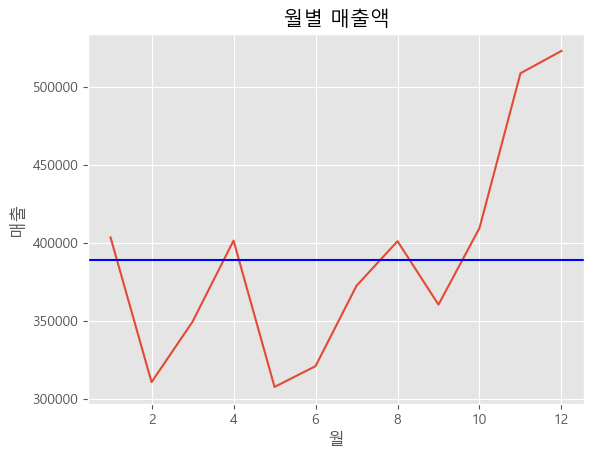

In [90]:
# 그래프 그리기
sns.lineplot(data=monthly_sales, x='월', y='매출')
plt.axhline(np.mean(monthly_sales['매출']), color='b')
plt.title("월별 매출액")
plt.show()

11월과 12월에 급격한 매출 증가를 확인할 수 있다. 
2월과 5월이 특별히 낮은 이유도 궁금하다. 

1월은 평균에 근접한 것으로 보아 계절성이라고 볼 수 있을까?

원인 분석이 필요함